### Step 1 - Loading Data and Exploratory Analysis

First five rows of the dataset:
                                                text  exclude_gpt  \
0  TORRICELLI HOLDINGS LTD. ACCOUNT NUMBER : 6105...            0   
1                                      PREPARED FOR:            0   
2                      STATEMENT OF INVESTMENTS\n===            0   
3                                          31-Mar-24            0   
4  YOUR PORTFOLIO MANAGER Scott Guitard, BBA (Fin...            0   

   confidence_gpt  exclude_llama  svm_class  char_count  \
0        0.383237            0.0          0          74   
1        0.490521            0.0          1          13   
2        0.801490            0.0          0          28   
3        0.460641            0.0          0          14   
4        0.591784            0.0          0          88   

                                           file_name  
0  Torricelli_TAXABLE_61059_CA_EN_MAR_2024_M9_202...  
1  Torricelli_TAXABLE_61059_CA_EN_MAR_2024_M9_202...  
2  Torricelli_TAXABLE_61059_CA_EN

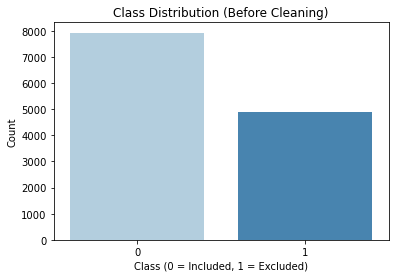

In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'excerpt_relevance_classification_data.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Check the basic structure of the data
print("First five rows of the dataset:")
print(data.head())

# Initial class distribution plot (before cleaning)
plt.figure(figsize=(6, 4))
sns.countplot(x='exclude_gpt', data=data, palette='Blues')
plt.title("Class Distribution (Before Cleaning)")
plt.xlabel("Class (0 = Included, 1 = Excluded)")
plt.ylabel("Count")
plt.show()


### Step 2 - Data Cleaning

Removing duplicates

Class counts before removing duplicates:
0    7928
1    4910
Name: exclude_gpt, dtype: int64
Number of duplicate rows: 8177
Class counts after removing duplicates:
0    3642
1    1019
Name: exclude_gpt, dtype: int64


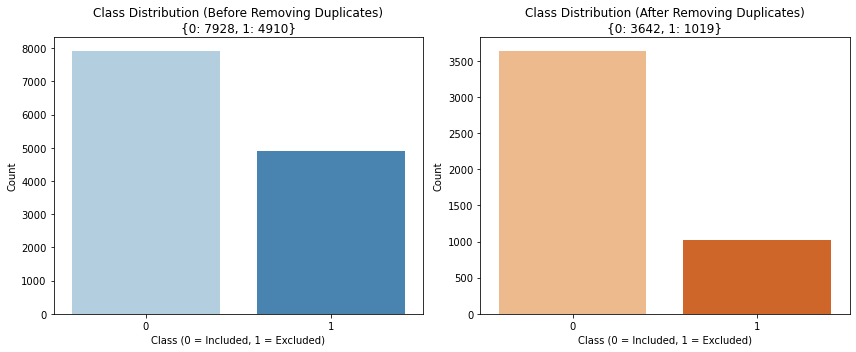

In [2]:
# Select the relevant columns for the analysis
selected_columns = data[['text', 'exclude_gpt']]

# Calculate the class counts before removing duplicates
class_counts_before = selected_columns['exclude_gpt'].value_counts()
print("Class counts before removing duplicates:")
print(class_counts_before)

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Class distribution before removing duplicates (Left)
sns.countplot(x='exclude_gpt', data=selected_columns, palette='Blues', ax=axes[0])
axes[0].set_title(f"Class Distribution (Before Removing Duplicates)\n{class_counts_before.to_dict()}")
axes[0].set_xlabel("Class (0 = Included, 1 = Excluded)")
axes[0].set_ylabel("Count")

# Check for duplicates in 'text' and 'exclude_gpt' columns
duplicate_rows = selected_columns.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Remove duplicates
cleaned_data = selected_columns.drop_duplicates()

# Calculate the class counts after removing duplicates
class_counts_after = cleaned_data['exclude_gpt'].value_counts()
print("Class counts after removing duplicates:")
print(class_counts_after)

# Class distribution after removing duplicates (Right)
sns.countplot(x='exclude_gpt', data=cleaned_data, palette='Oranges', ax=axes[1])
axes[1].set_title(f"Class Distribution (After Removing Duplicates)\n{class_counts_after.to_dict()}")
axes[1].set_xlabel("Class (0 = Included, 1 = Excluded)")
axes[1].set_ylabel("Count")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


Handling conflicting labels

Class counts before removing conflicts:
0    3642
1    1019
Name: exclude_gpt, dtype: int64
Class counts after removing conflicts:
0    3577
1     954
Name: exclude_gpt, dtype: int64


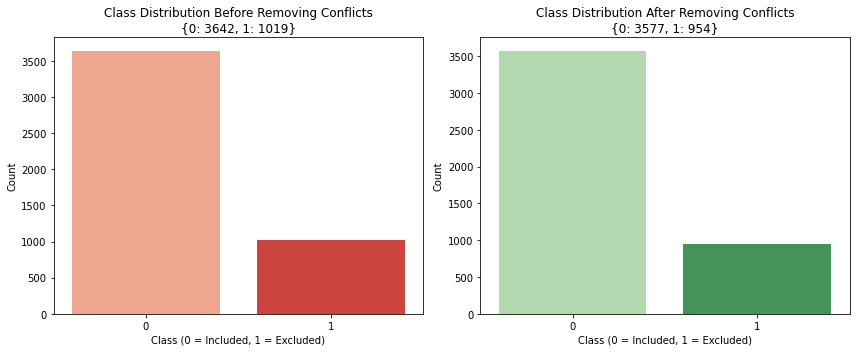

In [3]:
# Search for conflicting labels (same text with different exclude_gpt values)
conflicting_labels = cleaned_data.groupby('text')['exclude_gpt'].nunique()
conflicting_texts = conflicting_labels[conflicting_labels > 1].index

# Calculate the class counts before removing conflicts
class_counts_before_conflict = cleaned_data['exclude_gpt'].value_counts()
print("Class counts before removing conflicts:")
print(class_counts_before_conflict)

# Remove conflicting rows
conflicting_data = cleaned_data[cleaned_data['text'].isin(conflicting_texts)]
cleaned_data_no_conflicts = cleaned_data[~cleaned_data['text'].isin(conflicting_texts)]

# Calculate the class counts after removing conflicts
class_counts_after_conflict = cleaned_data_no_conflicts['exclude_gpt'].value_counts()
print("Class counts after removing conflicts:")
print(class_counts_after_conflict)

# Display the class distribution before and after removing conflicts (side by side)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot before removing conflicts
sns.countplot(x='exclude_gpt', data=cleaned_data, palette='Reds', ax=ax[0])
ax[0].set_title(f"Class Distribution Before Removing Conflicts\n{class_counts_before_conflict.to_dict()}")
ax[0].set_xlabel("Class (0 = Included, 1 = Excluded)")
ax[0].set_ylabel("Count")

# Plot after removing conflicts
sns.countplot(x='exclude_gpt', data=cleaned_data_no_conflicts, palette='Greens', ax=ax[1])
ax[1].set_title(f"Class Distribution After Removing Conflicts\n{class_counts_after_conflict.to_dict()}")
ax[1].set_xlabel("Class (0 = Included, 1 = Excluded)")
ax[1].set_ylabel("Count")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


### Step 3 - Split Data (80% Train, 20% Test)

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Encode the target labels (0 for included, 1 for excluded)
label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(cleaned_data_no_conflicts['exclude_gpt'])

# Apply TF-IDF Vectorization to the text column
tfidf = TfidfVectorizer(max_features=5000)
X_cleaned = tfidf.fit_transform(cleaned_data_no_conflicts['text']).toarray()

# Split the dataset into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)


### Step 4 - Trainning Models (80%) (20%)

Epoch 1/10


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6799 - loss: 0.5870 - val_accuracy: 0.9372 - val_loss: 0.2583
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9459 - loss: 0.2096 - val_accuracy: 0.9426 - val_loss: 0.1439
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9675 - loss: 0.0776 - val_accuracy: 0.9426 - val_loss: 0.1520
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9849 - loss: 0.0452 - val_accuracy: 0.9481 - val_loss: 0.1631
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9920 - loss: 0.0293 - val_accuracy: 0.9508 - val_loss: 0.1735
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9885 - loss: 0.0325 - val_accuracy: 0.9481 - val_loss: 0.1758
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9874 - loss: 0.0317 - val_accuracy: 0.9235 - val_loss: 0.2141
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9899 - loss: 0.0227 - val_accuracy: 0.9290 - val_loss: 0.

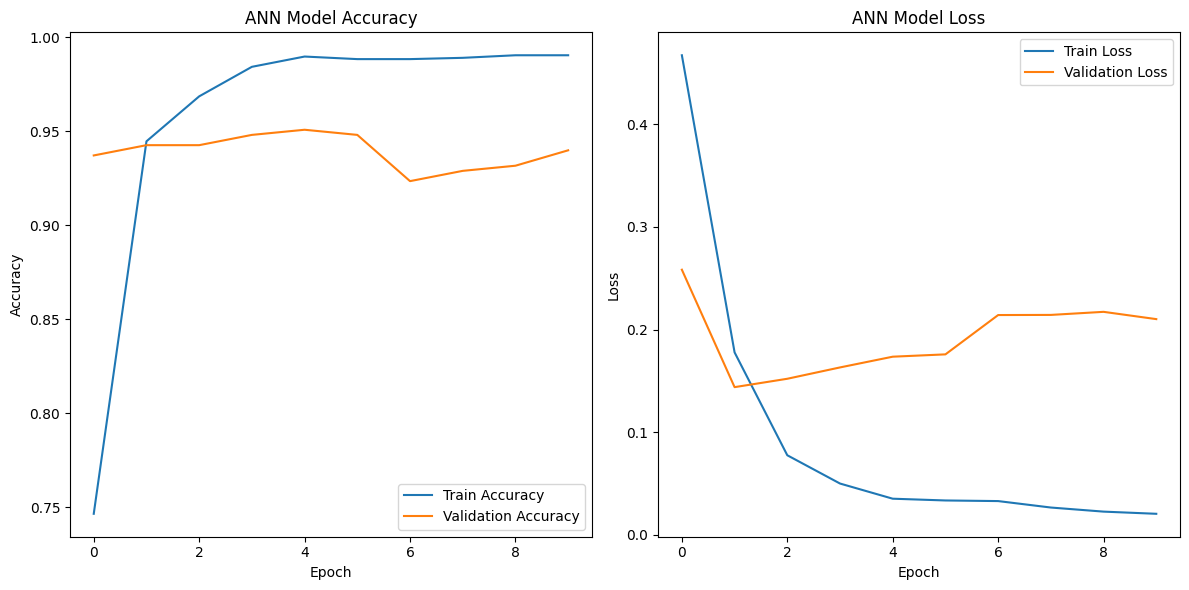

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix - ANN Model


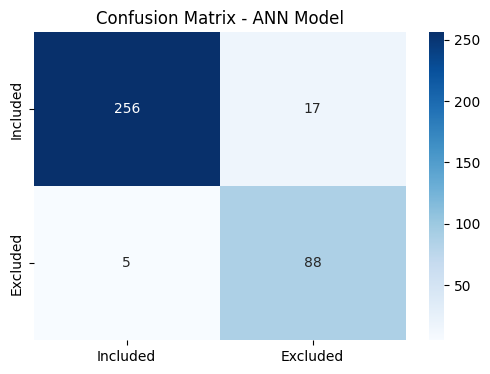

Classification Report - ANN Model
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       273
           1       0.84      0.95      0.89        93

    accuracy                           0.94       366
   macro avg       0.91      0.94      0.92       366
weighted avg       0.94      0.94      0.94       366



In [5]:

import tensorflow as tf

# Build the ANN model
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=X_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the ANN model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save history for performance analysis
ann_history = ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['accuracy'], label='Train Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ann_history.history['loss'], label='Train Loss')
plt.plot(ann_history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predict using the ANN model
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32")

# Display the confusion matrix and classification report for ANN
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)
class_report_ann = classification_report(y_test, y_pred_ann)

print("Confusion Matrix - ANN Model")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
plt.title("Confusion Matrix - ANN Model")
plt.show()

print("Classification Report - ANN Model")
print(class_report_ann)


### 5 - Training using 10-CV technique, Saving Models and Inference 

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf
import joblib
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming `cleaned_data_no_conflicts` is already defined and contains your cleaned data
# Select relevant columns
X = cleaned_data_no_conflicts['text']
y = cleaned_data_no_conflicts['exclude_gpt']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom ANN classifier compatible with sklearn pipelines
class ANNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=10, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.input_dim = None  # Input dimension will be set after TF-IDF

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, input_dim=self.input_dim, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.input_dim = X.shape[1]  # Set input_dim based on the TF-IDF output shape
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        y_pred = (self.model.predict(X) > 0.5).astype("int32")
        return y_pred

    def predict_proba(self, X):
        proba = self.model.predict(X)
        return np.hstack([1-proba, proba])  # return probabilities for both classes

# Step 1: Build a pipeline with TF-IDF and ANN
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # This will dynamically determine the feature count
    ('ann', ANNClassifier(epochs=10, batch_size=32))  # No fixed input_dim here
])

# Step 2: Perform 10-fold cross-validation and output accuracy for each fold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the pipeline on this fold
    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_val_pred = pipeline.predict(X_val_fold)
    
    # Calculate accuracy for this fold and save it
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    fold_accuracies.append(fold_accuracy)
    
    print(f"Fold {fold} Accuracy: {fold_accuracy:.4f}")

# Step 3: Calculate and print the average cross-validation accuracy
average_cv_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_cv_accuracy:.4f}")

# Step 4: Evaluate the pipeline on the test set
pipeline.fit(X_train, y_train)  # Re-train on the entire training set
y_test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 5: Save the pipeline
joblib.dump(pipeline, 'text_classification_ann_pipeline_cleaned.pkl')
print("Pipeline with ANN model saved as text_classification_ann_pipeline_cleaned.pkl")


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Fold 1 Accuracy: 0.9048


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 2 Accuracy: 0.9388


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 3 Accuracy: 0.9252


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 4 Accuracy: 0.9184


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Fold 5 Accuracy: 0.9315


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 6 Accuracy: 0.9110


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 7 Accuracy: 0.9110


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Fold 8 Accuracy: 0.8904


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Fold 9 Accuracy: 0.8973


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 10 Accuracy: 0.9315

Average Cross-Validation Accuracy: 0.9160


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Accuracy: 0.9399
Pipeline with ANN model saved as text_classification_ann_pipeline_cleaned.pkl


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       273
           1       0.86      0.91      0.89        93

    accuracy                           0.94       366
   macro avg       0.91      0.93      0.92       366
weighted avg       0.94      0.94      0.94       366


Confusion Matrix:
[[259  14]
 [  8  85]]


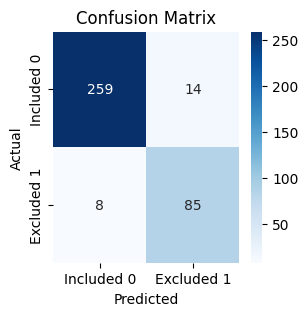

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the pipeline has been trained on the full training set
# Step 1: Make predictions on the test set
y_test_pred = pipeline.predict(X_test)

# Step 2: Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Step 3: Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix using Seaborn for better visualization
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Included 0', 'Excluded 1'], yticklabels=['Included 0', 'Excluded 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


loading the model for inference

In [11]:
import joblib
import pandas as pd

# Load the saved pipeline
pipeline = joblib.load('text_classification_ann_pipeline_cleaned.pkl')

y_pred = pipeline.predict(X_test)

# Optionally, get prediction probabilities (for binary classification)
y_prob = pipeline.predict_proba(X_test)

# Output predictions and probabilities for a few samples
for i in range(5):
    print(f"Text: {X_test.iloc[i]}")
    print(f"Prediction: {y_pred[i]} (0 = Included, 1 = Excluded)")
    print(f"Probability: {y_prob[i]}")
    print('-' * 50)

# If you want to evaluate the performance of the model, you can calculate accuracy or other metrics
from sklearn.metrics import accuracy_score, classification_report

# Assuming y_test contains the true labels
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print the classification report for precision, recall, F1-score, etc.
print("Classification Report:")
print(classification_report(y_test, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Text: Investments
Prediction: [0] (0 = Included, 1 = Excluded)
Probability: [9.999600e-01 3.999941e-05]
--------------------------------------------------
Text: A: We receive these fees from others in connection with some of the investments you purchased or the services and advice you received.
Prediction: [1] (0 = Included, 1 = Excluded)
Probability: [0.07227141 0.9277286 ]
--------------------------------------------------
Text: This statement may represent a credit note for trailer fees received in a previous billing period. Trailer fee rebates received in a non-registered account may be taxable. You should consult
Prediction: [1] (0 = Included, 1 = Excluded)
Probability: [0.00338763 0.99661237]
--------------------------------------------------
Text: | | Number of Units | Description | Book Cost ($) | Price on Oct 31 ($) | Value on Oct 31 ($) |
| - | - | - | - | - | - |
| Cash and | | Cash | 0.00 | 1.00

Example

In [12]:
import joblib

# Step 1: Load the saved pipeline
pipeline = joblib.load('text_classification_ann_pipeline_cleaned.pkl')

# Step 2: Prepare the custom input text
new_text = ["U.S. EQUITIES -- $302,782.81 INTERNATIONAL EQUITIES -- $238,204.06,0,0.589636538"]

# Step 3: Use the pipeline to predict the class
prediction = pipeline.predict(new_text)

# Step 4: Get the probability of the prediction
probability = pipeline.predict_proba(new_text)

# Step 5: Output the results with explicit labels
print(f"Input Text: {new_text[0]}")
print(f"Prediction: {prediction[0]} (0 = Included, 1 = Excluded)")
print(f"Probability of Included Class (0): {probability[0][0]}")
print(f"Probability of Excluded Class (1): {probability[0][1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input Text: U.S. EQUITIES -- $302,782.81 INTERNATIONAL EQUITIES -- $238,204.06,0,0.589636538
Prediction: [0] (0 = Included, 1 = Excluded)
Probability of Included Class (0): 0.9999961256980896
Probability of Excluded Class (1): 3.898383511113934e-06


# Cross Validation (Additional Experimentation)

## ANN

Training Fold 1 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training Fold 2 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E22A754040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Fold 3 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training Fold 4 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training Fold 5 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Fold 6 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Fold 7 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Fold 8 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Training Fold 9 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Fold 10 ...


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Average Cross-Validation Accuracy: 0.9187


c:\Users\Cristalinfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       273
           1       0.89      0.91      0.90        93

    accuracy                           0.95       366
   macro avg       0.93      0.94      0.94       366
weighted avg       0.95      0.95      0.95       366



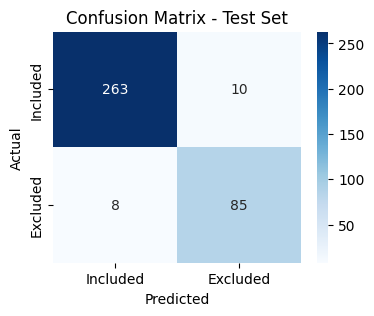

In [6]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
import matplotlib.pyplot as plt 
import seaborn as sns

# Fix the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Perform train-test split while keeping track of original indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_cleaned, y_cleaned, cleaned_data_no_conflicts.index, test_size=0.2, random_state=42
)

# Initialize the 10-Fold Cross Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder to store accuracy for each fold
fold_accuracies = []
confusion_matrices = []

# Build the ANN model function for re-initialization at each fold
def create_ann_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, input_dim=X_train.shape[1], activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Perform cross-validation
fold_num = 1
for train_idx, val_idx in kfold.split(X_train, y_train):
    print(f"Training Fold {fold_num} ...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Initialize the ANN model for each fold
    ann_model = create_ann_model()
    
    # Train the model
    ann_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    
    # Predict on the validation fold
    y_pred_val = (ann_model.predict(X_val_fold) > 0.5).astype("int32")
    
    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val)
    fold_accuracies.append(fold_accuracy)
    
    # Compute confusion matrix and store it
    conf_matrix = confusion_matrix(y_val_fold, y_pred_val)
    confusion_matrices.append(conf_matrix)
    
    # Print Classification Report for each fold
    #print(f"Fold {fold_num} Classification Report:")
    #print(classification_report(y_val_fold, y_pred_val))
    
    # Plot confusion matrix for each fold
    #plt.figure(figsize=(4, 3))
    #sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
    #plt.title(f'Confusion Matrix - Fold {fold_num}') 
    #plt.xlabel('Predicted') 
    #plt.ylabel('Actual') 
    #plt.show()
    
    fold_num += 1

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy:.4f}")

# Evaluate the model on the final 20% test set
ann_model_final = create_ann_model()
ann_model_final.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_test = (ann_model_final.predict(X_test) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred_test)

# Save the results in a DataFrame
results_df = pd.DataFrame({
    'Fold': list(range(1, 11)),
    'Accuracy': fold_accuracies
})
results_df.loc[len(results_df)] = ['Average', average_accuracy]
results_df.loc[len(results_df)] = ['Test Accuracy', test_accuracy]

# Save the accuracies and confusion matrices to a CSV file
results_df.to_csv('cross_validation_results_ann.csv', index=False)
pd.to_pickle(confusion_matrices, 'confusion_matrices_ann.pkl')

# Display final test results
print(f"Test Set Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
plt.title(f'Confusion Matrix - Test Set') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

# Load the results later
# results_loaded = pd.read_csv('cross_validation_results_ann.csv') 
# confusion_matrices_loaded = pd.read_pickle('confusion_matrices_ann.pkl')


In [32]:
# Load the results later
results_loaded = pd.read_csv('cross_validation_results.csv')
confusion_matrices_loaded = pd.read_pickle('confusion_matrices.pkl')

In [33]:
results_loaded

,Fold,Accuracy
0,1,0.911565
1,2,0.938776
2,3,0.945578
3,4,0.918367
4,5,0.931507
5,6,0.924658
6,7,0.904110
7,8,0.890411
8,9,0.904110
9,10,0.924658


In [38]:
import pandas as pd

# Define a function to get correctly classified samples for an ANN model
def display_correctly_classified_samples(ann_model, X_test, y_test, test_indices, data):
    """
    Display the correctly classified samples from the test set, showing the sample's original text, 
    true label, and predicted label in a Pandas DataFrame.
    
    Parameters:
    ann_model : Trained ANN model
    X_test : Test feature data (scaled or transformed)
    y_test : True labels for the test data (should be a NumPy array)
    test_indices : Original indices of the test data in the full dataset
    data : Original dataset that includes the 'text' column

    Returns:
    DataFrame with correctly classified samples including their original text, true label, and predicted label
    """

    # Predict on the test set
    y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32")

    # Flatten the predictions to ensure the correct shape for comparison
    y_pred_ann_flat = y_pred_ann.flatten()

    # Identify the correctly classified samples (where true label equals predicted label)
    correctly_classified_indices = [i for i in range(len(y_test)) if y_test[i] == y_pred_ann_flat[i]]

    # Use the original test_indices to map back to the original data
    correctly_classified_test_indices = [test_indices[i] for i in correctly_classified_indices]

    # Retrieve the corresponding original text using the correctly classified indices
    original_texts_correctly_classified = data.loc[correctly_classified_test_indices, 'text']

    # Create a DataFrame with the correctly classified samples, true labels, and predicted labels
    correctly_classified_samples_df = pd.DataFrame({
        'Original Index': correctly_classified_test_indices,
        'Original Text': original_texts_correctly_classified,
        'True Label': y_test[correctly_classified_indices],
        'Predicted Label': y_pred_ann_flat[correctly_classified_indices]  # Use flattened predictions
    })

    return correctly_classified_samples_df

# Example of how to call the function after training the ANN model:
correctly_classified_df = display_correctly_classified_samples(ann_model, X_test, y_test, test_indices, data)

# Display the DataFrame with correctly classified samples 
print(correctly_classified_df)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
      Original Index                                      Original Text  \
529              529                                        Investments   
2994            2994  A: We receive these fees from others in connec...   
3604            3604  This statement may represent a credit note for...   
2751            2751  | | Number of Units | Description | Book Cost ...   
763              763  | Date | Activity | Description | Quantity | P...   
...              ...                                                ...   
2986            2986  \* An investment fund pays a management fee to...   
3002            3002  · The definition of the total percentage retur...   
3250            3250              Income Summary U.S. DOLLARS Dividends   
3548            3548  |\n|| Pate Activity !  | | | Number of shares ...   
1439            1439  $1,043,651.30\n :selected:\nAsset Allocation T...   

      True Label  Predicted Label  
529            0        

In [ ]:
import pandas as pd

# Define a function to get incorrectly classified samples for an ANN model
def display_incorrectly_classified_samples(ann_model, X_test, y_test, test_indices, data):
    """
    Display the incorrectly classified samples from the test set, showing the sample's original text, 
    true label, and predicted label in a Pandas DataFrame.
    
    Parameters:
    ann_model : Trained ANN model
    X_test : Test feature data (scaled or transformed)
    y_test : True labels for the test data (should be a NumPy array)
    test_indices : Original indices of the test data in the full dataset
    data : Original dataset that includes the 'text' column

    Returns:
    DataFrame with incorrectly classified samples including their original text, true label, and predicted label
    """

    # Predict on the test set
    y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32")

    # Flatten the predictions to ensure the correct shape for comparison
    y_pred_ann_flat = y_pred_ann.flatten()

    # Identify the incorrectly classified samples (where true label is NOT equal to predicted label)
    incorrectly_classified_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred_ann_flat[i]]

    # Use the original test_indices to map back to the original data
    incorrectly_classified_test_indices = [test_indices[i] for i in incorrectly_classified_indices]

    # Retrieve the corresponding original text using the incorrectly classified indices
    original_texts_incorrectly_classified = data.loc[incorrectly_classified_test_indices, 'text']

    # Create a DataFrame with the incorrectly classified samples, true labels, and predicted labels
    incorrectly_classified_samples_df = pd.DataFrame({
        'Original Index': incorrectly_classified_test_indices,
        'Original Text': original_texts_incorrectly_classified,
        'True Label': y_test[incorrectly_classified_indices],
        'Predicted Label': y_pred_ann_flat[incorrectly_classified_indices]  # Use flattened predictions
    })

    return incorrectly_classified_samples_df

# Example of how to call the function after training the ANN model:
incorrectly_classified_df = display_incorrectly_classified_samples(ann_model, X_test, y_test, test_indices, data)

# Display the DataFrame with incorrectly classified samples 
print(incorrectly_classified_df)


In [40]:
incorrectly_classified_df

,Original Index,Original Text,True Label,Predicted Label
2814,2814,53324,0,1
2775,2775,## 2\. Connected Issuers to the Registrants,0,1
2541,2541,. We've updated the Commission and Fees Schedu...,0,1
2583,2583,:selected:\nAvailable\n :selected:\nUnavailable,0,1
3490,3490,DIACONU M,0,1
515,515,EasyWeb,1,0
2803,2803,## For Regular Investment Plans:,0,1
519,519,Goals Learn,0,1
2993,2993,Q: Why does CIBC Wood Gundy receive fees from ...,1,0
4104,4104,|||\n| - | - |\n| Share classes NVS | Non-voti...,0,1


## SVM

Training Fold 1 ...
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       109
           1       0.59      0.87      0.70        38

    accuracy                           0.81       147
   macro avg       0.77      0.83      0.78       147
weighted avg       0.85      0.81      0.82       147



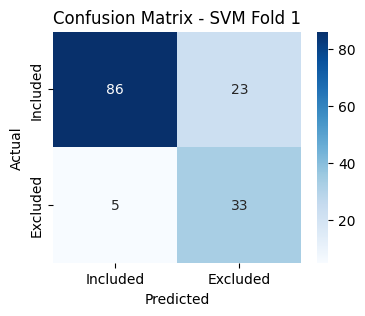

Training Fold 2 ...
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       108
           1       0.70      0.85      0.77        39

    accuracy                           0.86       147
   macro avg       0.82      0.86      0.84       147
weighted avg       0.88      0.86      0.87       147



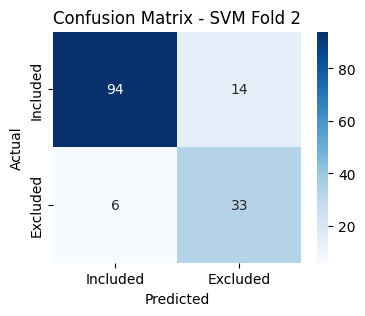

Training Fold 3 ...
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       108
           1       0.63      0.85      0.73        39

    accuracy                           0.83       147
   macro avg       0.79      0.84      0.80       147
weighted avg       0.86      0.83      0.84       147



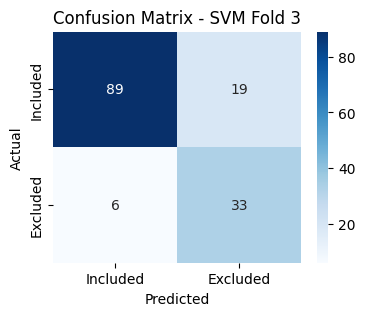

Training Fold 4 ...
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       108
           1       0.56      0.79      0.66        39

    accuracy                           0.78       147
   macro avg       0.74      0.79      0.75       147
weighted avg       0.82      0.78      0.79       147



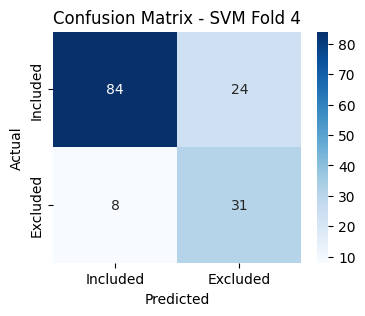

Training Fold 5 ...
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       108
           1       0.61      0.87      0.72        38

    accuracy                           0.82       146
   macro avg       0.78      0.84      0.79       146
weighted avg       0.86      0.82      0.83       146



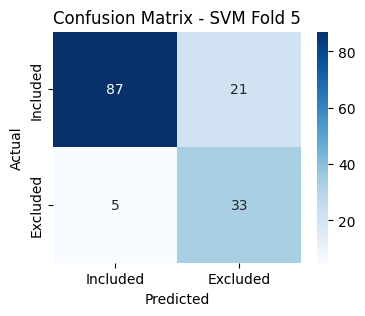

Training Fold 6 ...
Fold 6 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       108
           1       0.55      0.79      0.65        38

    accuracy                           0.77       146
   macro avg       0.73      0.78      0.74       146
weighted avg       0.82      0.77      0.78       146



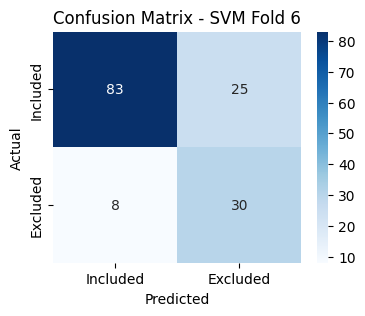

Training Fold 7 ...
Fold 7 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       108
           1       0.58      0.82      0.68        38

    accuracy                           0.80       146
   macro avg       0.75      0.81      0.77       146
weighted avg       0.84      0.80      0.81       146



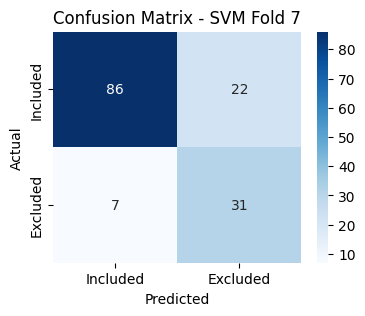

Training Fold 8 ...
Fold 8 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       108
           1       0.64      0.79      0.71        38

    accuracy                           0.83       146
   macro avg       0.78      0.82      0.79       146
weighted avg       0.85      0.83      0.83       146



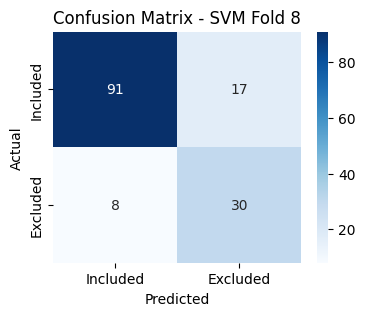

Training Fold 9 ...
Fold 9 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       108
           1       0.63      0.87      0.73        38

    accuracy                           0.84       146
   macro avg       0.79      0.85      0.81       146
weighted avg       0.87      0.84      0.84       146



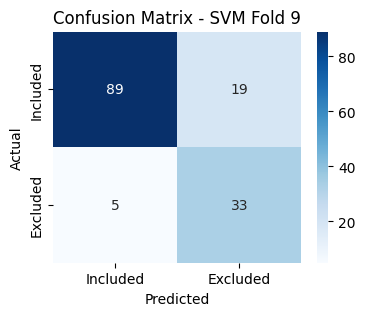

Training Fold 10 ...
Fold 10 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       108
           1       0.62      0.79      0.70        38

    accuracy                           0.82       146
   macro avg       0.77      0.81      0.79       146
weighted avg       0.84      0.82      0.83       146



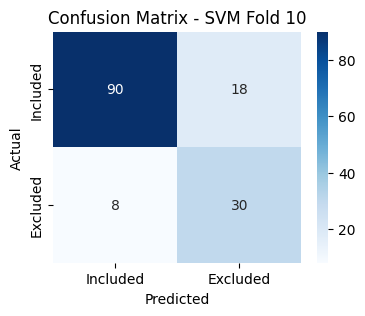


Average Cross-Validation Accuracy: 0.8169
Test Set Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       273
           1       0.62      0.87      0.72        93

    accuracy                           0.83       366
   macro avg       0.78      0.84      0.80       366
weighted avg       0.86      0.83      0.84       366



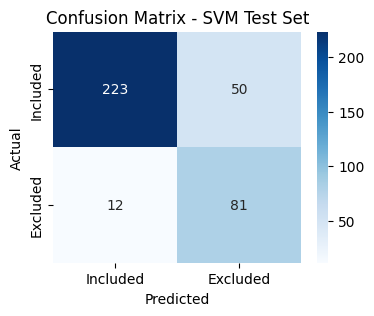

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Fix the random seed for reproducibility
np.random.seed(42)

# Scale the data
scaler = StandardScaler()
X_cleaned_scaled = scaler.fit_transform(X_cleaned)

# Split the dataset into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_scaled, y_cleaned, test_size=0.2, random_state=42)

# Initialize the 10-Fold Cross Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder to store accuracy for each fold
fold_accuracies = []
confusion_matrices = []

# Perform cross-validation for SVM
fold_num = 1
for train_idx, val_idx in kfold.split(X_train, y_train):
    print(f"Training Fold {fold_num} ...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Initialize and train the SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred_val = svm_model.predict(X_val_fold)
    
    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val)
    fold_accuracies.append(fold_accuracy)
    
    # Compute confusion matrix and store it
    conf_matrix = confusion_matrix(y_val_fold, y_pred_val)
    confusion_matrices.append(conf_matrix)
    
    # Print Classification Report for each fold
    print(f"Fold {fold_num} Classification Report:")
    print(classification_report(y_val_fold, y_pred_val))
    
    # Plot confusion matrix for each fold
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
    plt.title(f'Confusion Matrix - SVM Fold {fold_num}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    fold_num += 1

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy:.4f}")

# Evaluate the model on the final 20% test set
svm_model_final = SVC(kernel='linear', random_state=42)
svm_model_final.fit(X_train, y_train)
y_pred_test = svm_model_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Save the results in a DataFrame
results_df = pd.DataFrame({
    'Fold': list(range(1, 11)),
    'Accuracy': fold_accuracies
})
results_df.loc[len(results_df)] = ['Average', average_accuracy]
results_df.loc[len(results_df)] = ['Test Accuracy', test_accuracy]

# Save the accuracies and confusion matrices to a CSV file with SVM in the filename
results_df.to_csv('svm_cross_validation_results.csv', index=False)
pd.to_pickle(confusion_matrices, 'svm_confusion_matrices.pkl')

# Display final test results
print(f"Test Set Classification Report (SVM):")
print(classification_report(y_test, y_pred_test))

# Plot the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
plt.title(f'Confusion Matrix - SVM Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Load the results later (if needed)
# results_loaded = pd.read_csv('svm_cross_validation_results.csv')
# confusion_matrices_loaded = pd.read_pickle('svm_confusion_matrices.pkl')



## RF

Training Fold 1 ...
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       109
           1       0.67      0.95      0.78        38

    accuracy                           0.86       147
   macro avg       0.82      0.89      0.84       147
weighted avg       0.90      0.86      0.87       147



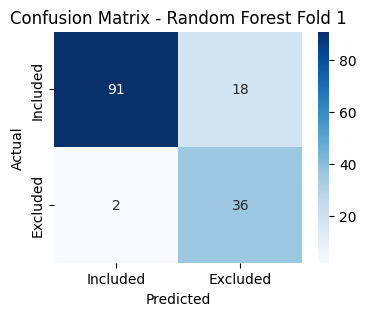

Training Fold 2 ...
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       108
           1       0.77      0.95      0.85        39

    accuracy                           0.91       147
   macro avg       0.88      0.92      0.89       147
weighted avg       0.92      0.91      0.91       147



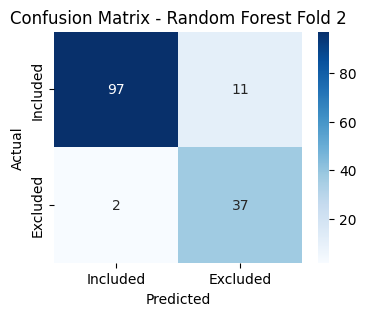

Training Fold 3 ...
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       108
           1       0.69      0.90      0.78        39

    accuracy                           0.86       147
   macro avg       0.82      0.87      0.84       147
weighted avg       0.89      0.86      0.87       147



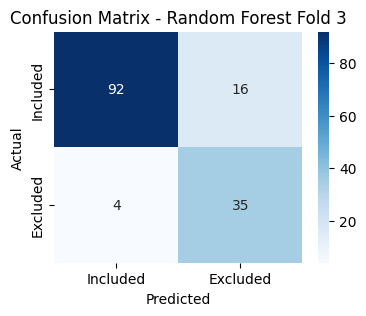

Training Fold 4 ...
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       108
           1       0.76      0.87      0.81        39

    accuracy                           0.89       147
   macro avg       0.85      0.88      0.87       147
weighted avg       0.90      0.89      0.89       147



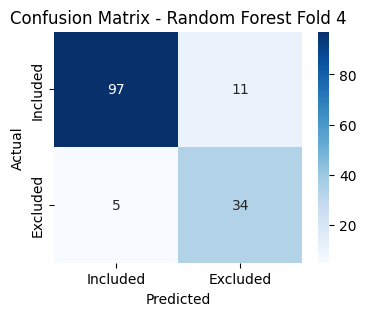

Training Fold 5 ...
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       108
           1       0.69      0.92      0.79        38

    accuracy                           0.87       146
   macro avg       0.83      0.89      0.85       146
weighted avg       0.89      0.87      0.88       146



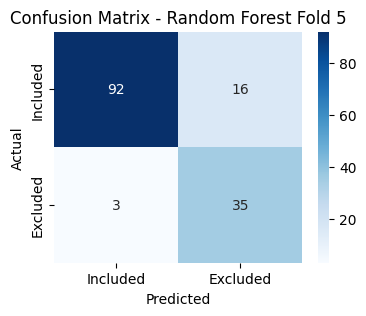

Training Fold 6 ...
Fold 6 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       108
           1       0.76      0.89      0.82        38

    accuracy                           0.90       146
   macro avg       0.86      0.90      0.87       146
weighted avg       0.91      0.90      0.90       146



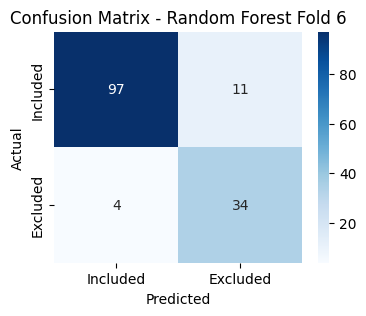

Training Fold 7 ...
Fold 7 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       108
           1       0.64      0.89      0.75        38

    accuracy                           0.84       146
   macro avg       0.80      0.86      0.82       146
weighted avg       0.87      0.84      0.85       146



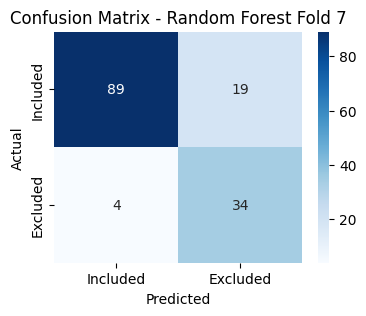

Training Fold 8 ...
Fold 8 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       108
           1       0.71      0.79      0.75        38

    accuracy                           0.86       146
   macro avg       0.82      0.84      0.83       146
weighted avg       0.87      0.86      0.87       146



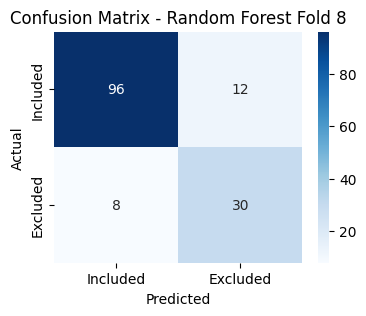

Training Fold 9 ...
Fold 9 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       108
           1       0.69      0.92      0.79        38

    accuracy                           0.87       146
   macro avg       0.83      0.89      0.85       146
weighted avg       0.89      0.87      0.88       146



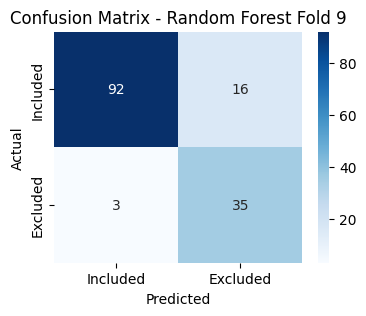

Training Fold 10 ...
Fold 10 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       108
           1       0.77      0.89      0.83        38

    accuracy                           0.90       146
   macro avg       0.87      0.90      0.88       146
weighted avg       0.91      0.90      0.91       146



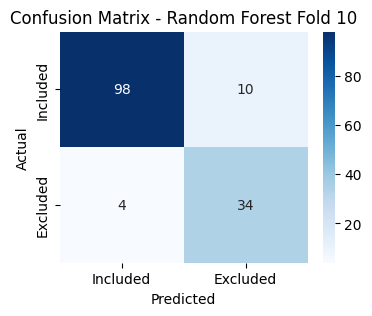


Average Cross-Validation Accuracy: 0.8777
Test Set Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       273
           1       0.69      0.90      0.78        93

    accuracy                           0.87       366
   macro avg       0.83      0.88      0.85       366
weighted avg       0.89      0.87      0.88       366



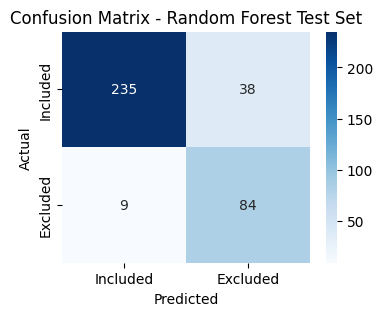

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Fix the random seed for reproducibility
np.random.seed(42)

# Scale the data (Random Forests don't necessarily need scaling, but for consistency)
scaler = StandardScaler()
X_cleaned_scaled = scaler.fit_transform(X_cleaned)

# Split the dataset into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_scaled, y_cleaned, test_size=0.2, random_state=42)

# Initialize the 10-Fold Cross Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder to store accuracy for each fold
fold_accuracies = []
confusion_matrices = []

# Perform cross-validation for Random Forest
fold_num = 1
for train_idx, val_idx in kfold.split(X_train, y_train):
    print(f"Training Fold {fold_num} ...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred_val = rf_model.predict(X_val_fold)
    
    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val)
    fold_accuracies.append(fold_accuracy)
    
    # Compute confusion matrix and store it
    conf_matrix = confusion_matrix(y_val_fold, y_pred_val)
    confusion_matrices.append(conf_matrix)
    
    # Print Classification Report for each fold
    print(f"Fold {fold_num} Classification Report:")
    print(classification_report(y_val_fold, y_pred_val))
    
    # Plot confusion matrix for each fold
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
    plt.title(f'Confusion Matrix - Random Forest Fold {fold_num}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    fold_num += 1

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy:.4f}")

# Evaluate the model on the final 20% test set
rf_model_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_final.fit(X_train, y_train)
y_pred_test = rf_model_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Save the results in a DataFrame
results_df = pd.DataFrame({
    'Fold': list(range(1, 11)),
    'Accuracy': fold_accuracies
})
results_df.loc[len(results_df)] = ['Average', average_accuracy]
results_df.loc[len(results_df)] = ['Test Accuracy', test_accuracy]

# Save the accuracies and confusion matrices to a CSV file with Random Forest in the filename
results_df.to_csv('random_forest_cross_validation_results.csv', index=False)
pd.to_pickle(confusion_matrices, 'random_forest_confusion_matrices.pkl')

# Display final test results
print(f"Test Set Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_test))

# Plot the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
plt.title(f'Confusion Matrix - Random Forest Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Load the results later (if needed)
# results_loaded = pd.read_csv('random_forest_cross_validation_results.csv')
# confusion_matrices_loaded = pd.read_pickle('random_forest_confusion_matrices.pkl')



## XGBOOST

In [6]:
!pip install xgboost

Training Fold 1 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       287
           1       0.90      0.79      0.84        76

    accuracy                           0.94       363
   macro avg       0.92      0.88      0.90       363
weighted avg       0.94      0.94      0.94       363



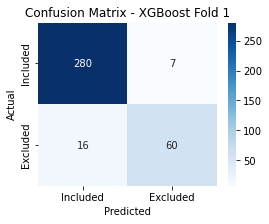

Training Fold 2 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       287
           1       0.92      0.80      0.86        76

    accuracy                           0.94       363
   macro avg       0.94      0.89      0.91       363
weighted avg       0.94      0.94      0.94       363



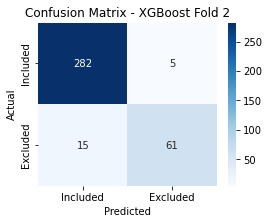

Training Fold 3 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       287
           1       0.84      0.87      0.85        76

    accuracy                           0.94       363
   macro avg       0.90      0.91      0.91       363
weighted avg       0.94      0.94      0.94       363



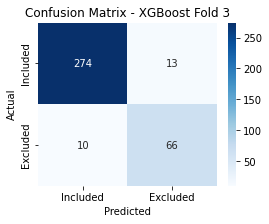

Training Fold 4 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       287
           1       0.91      0.82      0.86        76

    accuracy                           0.94       363
   macro avg       0.93      0.90      0.91       363
weighted avg       0.94      0.94      0.94       363



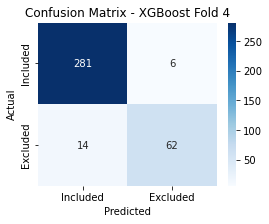

Training Fold 5 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       287
           1       0.88      0.79      0.83        75

    accuracy                           0.93       362
   macro avg       0.91      0.88      0.89       362
weighted avg       0.93      0.93      0.93       362



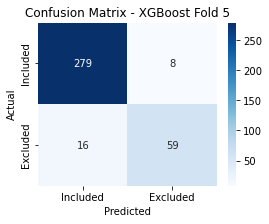

Training Fold 6 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 6 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       287
           1       0.90      0.83      0.86        75

    accuracy                           0.94       362
   macro avg       0.93      0.90      0.91       362
weighted avg       0.94      0.94      0.94       362



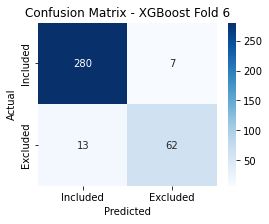

Training Fold 7 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 7 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       287
           1       0.95      0.72      0.82        75

    accuracy                           0.93       362
   macro avg       0.94      0.85      0.89       362
weighted avg       0.93      0.93      0.93       362



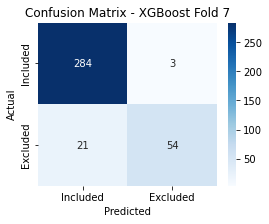

Training Fold 8 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 8 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       287
           1       0.93      0.87      0.90        75

    accuracy                           0.96       362
   macro avg       0.95      0.92      0.94       362
weighted avg       0.96      0.96      0.96       362



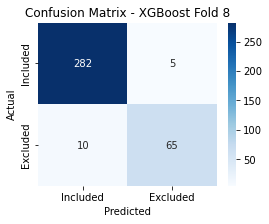

Training Fold 9 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 9 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       287
           1       0.92      0.81      0.87        75

    accuracy                           0.95       362
   macro avg       0.94      0.90      0.92       362
weighted avg       0.95      0.95      0.95       362



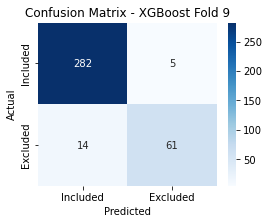

Training Fold 10 ...


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 10 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       287
           1       0.88      0.92      0.90        75

    accuracy                           0.96       362
   macro avg       0.93      0.94      0.94       362
weighted avg       0.96      0.96      0.96       362



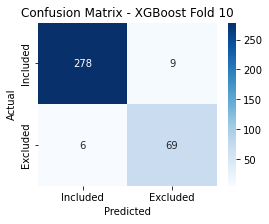


Average Cross-Validation Accuracy: 0.9440


c:\Users\abden\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       707
           1       0.90      0.82      0.86       200

    accuracy                           0.94       907
   macro avg       0.92      0.90      0.91       907
weighted avg       0.94      0.94      0.94       907



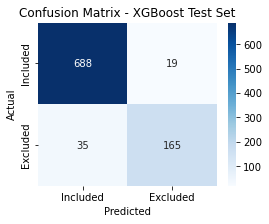

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Fix the random seed for reproducibility
np.random.seed(42)

# Scale the data
scaler = StandardScaler()
X_cleaned_scaled = scaler.fit_transform(X_cleaned)

# Split the dataset into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_scaled, y_cleaned, test_size=0.2, random_state=42)

# Initialize the 10-Fold Cross Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Placeholder to store accuracy for each fold
fold_accuracies = []
confusion_matrices = []

# Perform cross-validation for XGBoost
fold_num = 1
for train_idx, val_idx in kfold.split(X_train, y_train):
    print(f"Training Fold {fold_num} ...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Initialize and train the XGBoost model
    xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred_val = xgb_model.predict(X_val_fold)
    
    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val)
    fold_accuracies.append(fold_accuracy)
    
    # Compute confusion matrix and store it
    conf_matrix = confusion_matrix(y_val_fold, y_pred_val)
    confusion_matrices.append(conf_matrix)
    
    # Print Classification Report for each fold
    print(f"Fold {fold_num} Classification Report:")
    print(classification_report(y_val_fold, y_pred_val))
    
    # Plot confusion matrix for each fold
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
    plt.title(f'Confusion Matrix - XGBoost Fold {fold_num}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    fold_num += 1

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy:.4f}")

# Evaluate the model on the final 20% test set
xgb_model_final = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_final.fit(X_train, y_train)
y_pred_test = xgb_model_final.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Save the results in a DataFrame
results_df = pd.DataFrame({
    'Fold': list(range(1, 11)),
    'Accuracy': fold_accuracies
})
results_df.loc[len(results_df)] = ['Average', average_accuracy]
results_df.loc[len(results_df)] = ['Test Accuracy', test_accuracy]

# Save the accuracies and confusion matrices to a CSV file with XGBoost in the filename
results_df.to_csv('xgboost_cross_validation_results.csv', index=False)
pd.to_pickle(confusion_matrices, 'xgboost_confusion_matrices.pkl')

# Display final test results
print(f"Test Set Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_test))

# Plot the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Included', 'Excluded'], yticklabels=['Included', 'Excluded'])
plt.title(f'Confusion Matrix - XGBoost Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Load the results later (if needed)
# results_loaded = pd.read_csv('xgboost_cross_validation_results.csv')
# confusion_matrices_loaded = pd.read_pickle('xgboost_confusion_matrices.pkl')

